# Similarity explanations for 20 newsgroups dataset

In this notebook, we apply the similarity explanation method to a feed forward neural network (FFNN) trained on the 20 newsgroups dataset. 

The 20 newsgroups dataset is a corpus of 18846 text documents (emails) divided into 20 sections. The FFNN is trained to classify each document in the correct section. The model uses pre-trained sentence embeddings as input features, which are obtained from raw text using a [pretrained transformer](https://www.sbert.net/docs/pretrained_models.html). 

Given an input document of interest, the similarity explanation method used here aims to find text documents in the training set that are similar to the document of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters.

The similarity explanation tool supports both `pytorch` and `tensorflow` backends. In this example, we will use the `pytorch` backend.

A more detailed description of the method can be found [here](../methods/Similarity.ipynb). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/hash/c61f571dbd2fb949d3fe5ae1608dd48b-Abstract.html) and  [Hanawa et al. 2021](https://arxiv.org/abs/2006.04528).

In [2]:
import os
import torch
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from termcolor import colored
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])
    
def appendInt(num):
    """Converts integer into cardials (ex. 1 -> 1st, 2 -> 2nd, etc.)
    
    Parameters
    ----------
    num
        Integer number
    
    Returns
    -------
    Oridinal suffixes
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

## Load data

Loading and preparing the 20 newsgroups dataset.

In [4]:
example_idx = 4

print("Loading 20 news groups dataset")
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names
df = pd.DataFrame({'text': X, 'labels': y})

print("Cleaning text")
df['text_cleaned'] = df['text'].str.replace('\s+',' ')
df['text_cleaned'] = df['text_cleaned'].str.strip()
df['text_cleaned'] = df['text_cleaned'].str.slice(0,131072)
df = df.replace('', np.NaN).dropna()
df = df.drop_duplicates(subset='text_cleaned')
print('')

print(colored("Sample document before cleaning", 'red'))
print(f"{df['text'][example_idx]}")
print('')
print(colored("Sample document after cleaning", 'red'))
print(f"{df['text_cleaned'][example_idx]}")
print('')

print("Splitting train - test")
df_train, df_test = train_test_split(df, test_size=0.2)
X_train, y_train = df_train['text_cleaned'].values, df_train['labels'].values
X_test, y_test = df_test['text_cleaned'].values, df_test['labels'].values
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

Loading 20 news groups dataset
Cleaning text


The default value of regex will change from True to False in a future version.



Sample document before cleaning

So its an automatic? Don't know if US spec=CDN spec. for Maximas.


If it is the first set of brake pads on front, then this is fine. My car
eats a set every 15k miles or so. The fact that he is replacing the
muffler too is also ok.


The mileage is fairly low - but typical fwd stuff is CV joints. Check
the maintenance records with the manufacturers requirements for valve
adjustments, timing belt changes and so on.

The 60k mile service is often expensive, so make sure he has done everything.


Well, this is one of the commonly cited methods for identifying a
car with highway miles. 
Might check the gas pedal wear too. Ask him how many sets of tires he
has been through. A highway car might have squeezed by on 2 sets,
a hard driven car 6-10 sets.



Well, the Maxima should be pretty reliable - but if its out of warranty
you should get it checked out by someone knowledgeable first. Stuff
for Japanese cars can be expensive.


1995 model year, I believe. 


## Define and train model

We define and train a `pytorch` classifier using sentence embeddings as inputs.

### Define model

In [5]:
class EmbeddingModel:
    """Pre-trained sentence transformer wrapper.
    """
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

class Classifier(nn.Module):
    """FFNN classifier with pretrained sentence embeddings inputs.
    """
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

### Get sentence embeddings and define dataloaders

In [7]:
embedding_model = EmbeddingModel(device=device)

print('Getting train embeddings')    
embeddings_train = embedding_model(X_train)
train_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_train).to(device), 
                                       torch.Tensor(y_train).to(device)), 
                          batch_size=32, 
                          shuffle=True)

print('Getting test embeddings')  
embeddings_test = embedding_model(X_test)
test_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_test).to(device), 
                                      torch.Tensor(y_test).to(device)), 
                         batch_size=32, 
                         shuffle=False)

Getting train embeddings
Getting test embeddings


### Train model

In [8]:
epochs = 3

# initialize classifier
model = Classifier().to(device)
print('Training classifier')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        y_hat = model(x)
        optimizer.zero_grad()
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

Training classifier


100%|███████████████| 457/457 [00:00<00:00, 1124.40it/s]


### Evaluate model

Evaluating the model on train and test set. Since the dataset is well balanced, we only consider accuracy as evaluation metric.

In [9]:
def eval_model(model, loader):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            y_hat = model(x)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    accuracy = (preds == labels.argmax(axis=1)).mean()
    print(f'Accuracy: {accuracy:.3f}')
    
print('Train set evaluation')
eval_model(model, train_loader)
print('Test set evaluation')
eval_model(model, test_loader)

Train set evaluation
Accuracy: 0.717
Test set evaluation
Accuracy: 0.670


## Find similaraties 

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [10]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref]
embeddings_ref = embeddings_train[idxs_ref]
y_ref = y_train[idxs_ref]

Initializing a `GradientSimilarity` explainer instance.

In [11]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

Fitting the explainer on the reference data.

In [12]:
gsm.fit(embeddings_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set.

In [13]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, embeddings_sample, y_sample = X_test[idxs_samples], embeddings_test[idxs_samples], y_test[idxs_samples]

Getting predictions and explanations for each of the 5 test samples.

In [14]:
preds = model(torch.Tensor(embeddings_sample).to(device)).detach().cpu().numpy().argmax(axis=1)
expls = gsm.explain(embeddings_sample, y_sample)

## Visualizations 

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains:
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [15]:
ds = []
for j in range(len(embeddings_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    sim_embedding = embeddings_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(torch.Tensor(sim_embedding).to(device)).detach().cpu().numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

### Most similar instances

Showing the 3 most similar instances for each of the test instances.

In [16]:
for sample_nb in range(5):
    title = f"Sample nb {sample_nb}"
    print(colored(title, 'blue'))
    print(colored(f"{len(title) * '='}", 'blue'))
    print('')
    
    print(colored("Original instance - ", 'red'), 
          colored(f"Label: {target_names[ds[sample_nb]['y']]} - ", 'red'), 
          colored(f"Prediction: {target_names[ds[sample_nb]['pred']]}", 'red'))
    print(f"{ds[sample_nb]['x']}")
    print('')
    
    for i in range(3):
        print(colored(f"{i+1}{appendInt(i+1)} most similar instance - ", 'red'), 
              colored(f"Label: {target_names[ds[sample_nb]['y_sim'][i]]} - ", 'red'), 
              colored(f"Prediction: {target_names[ds[sample_nb]['preds_sim'][i]]}", 'red'))
        print(f"{ds[sample_nb]['x_sim'][i]}")
        print('')

Sample nb 0

Original instance -  Label: comp.sys.mac.hardware -  Prediction: sci.electronics
I'm also interested in Mac based BBS, but not in Chicago. I would greatly appreciate it if someone could post a list of BBSs in the LA area. Preferably (818) but also (213). Thanks. Dan

1st most similar instance -  Label: comp.sys.mac.hardware -  Prediction: comp.sys.mac.hardware
You can call MacUser magazine number, i guess they will give you the info!

2nd most similar instance -  Label: comp.sys.mac.hardware -  Prediction: comp.sys.mac.hardware
I really want to buy a powerbook and would like one that can run Mathematica. So I need a coprocessor but I can not afford a PB180. (who can?) Is it possible to put a MCP in a PB160? The guy at the bookstore says no but I didn't think he had too much of a clue. Please respond by e-mail: ross@sbphy.physics.ucsb.edu

3rd most similar instance -  Label: comp.sys.mac.hardware -  Prediction: comp.sys.mac.hardware
>With that in mind... I just recently pur

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class and to the same predicted class. 

In [37]:
def plot_distributions(ds, expls, target_names, figsize=(20, 5)):

    for i in range(len(ds)):
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False)
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})
        title = f"Sample nb {i}"
        print(colored(title, 'blue'))
        print(colored(f"{len(title) * '='}", 'blue'))
        print('')

        print(colored("Original instance", 'red'))
        print(colored(f"Label: section {d['y']}, {target_names[d['y']]}", 'red')) 
        print(colored(f"Prediction: section {d['pred']}, {target_names[d['pred']]}", 'red'))
        print(f"{d['x']}")
        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean()
        df_y.index = target_names
        df_y.sort_values(ascending=True).plot(kind='barh', ax=axes[0])
        axes[0].set_title("Averaged scores for each true class in reference set \n")
        
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean()
        df_preds.index = target_names
        df_preds.sort_values(ascending=True).plot(kind='barh', ax=axes[1])
        axes[1].set_title("Averaged scores for each predicted class in reference set \n")
        fig.tight_layout()
        plt.show()

Sample nb 0

Original instance
Label: section 4, comp.sys.mac.hardware
Prediction: section 12, sci.electronics
I'm also interested in Mac based BBS, but not in Chicago. I would greatly appreciate it if someone could post a list of BBSs in the LA area. Preferably (818) but also (213). Thanks. Dan


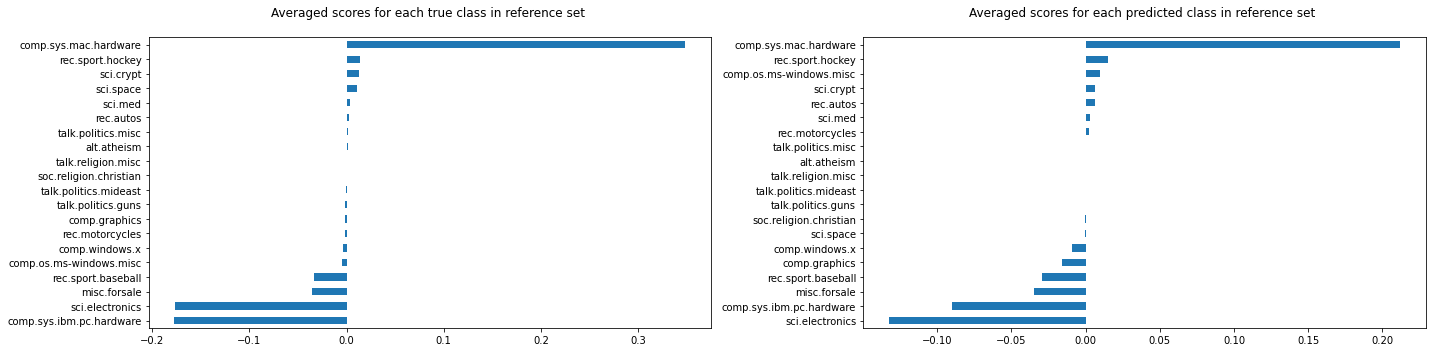

Sample nb 1

Original instance
Label: section 10, rec.sport.hockey
Prediction: section 10, rec.sport.hockey
Sorry to everyone for wasting space. Matt, the other day you posted that you were doing a mailing list of playoff stats. I lost your address. Please put me on that list. Thanks.


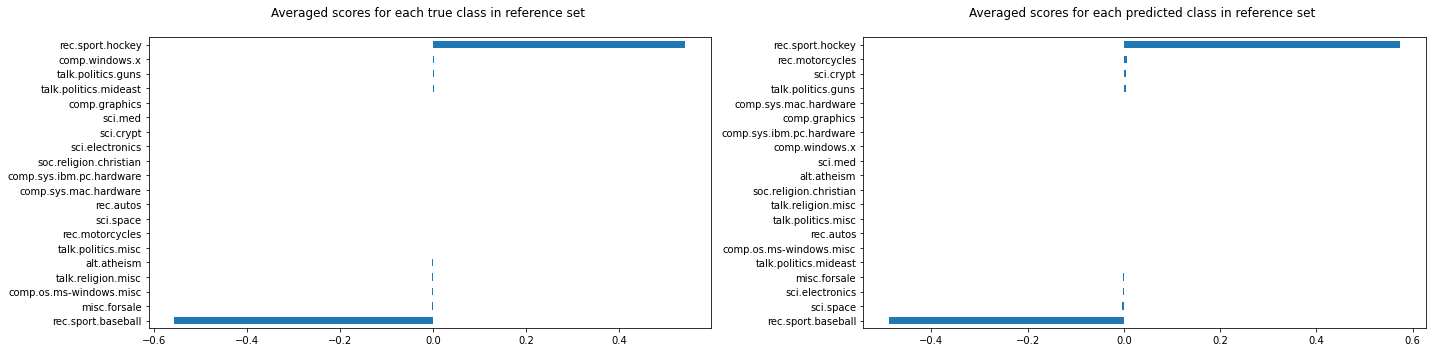

Sample nb 2

Original instance
Label: section 3, comp.sys.ibm.pc.hardware
Prediction: section 5, comp.windows.x
I don't think the two main free X systems ( XS3 and XFree86 ) are part of the FSF as such. Does anyone know of an e-mail address for Diamond to which Penio could forward his purchase information? Guy


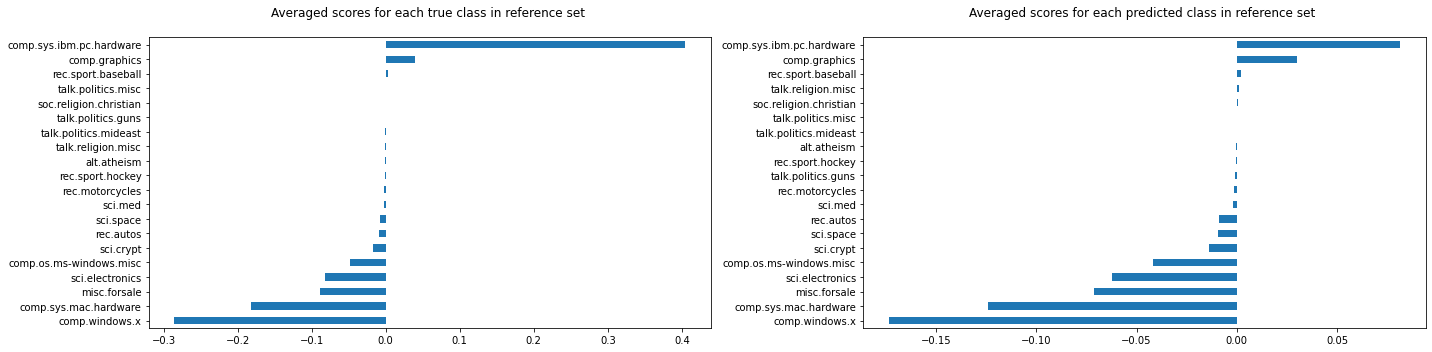

Sample nb 3

Original instance
Label: section 1, comp.graphics
Prediction: section 1, comp.graphics
Let's say you have a scanned image of a line drawing; in this case a boat, but it could be anything. On the drawing you have a set of reference points whose true x,y positions are known. Now you digitize the drawing manually (in this case, using Yaron Danon's excellent Digitize program). That is, you use a program which converts cursor positions to x,y and saves those values when you click the mouse. Upon digitizing you notice that the reference point values that come out of the digitizing process differ in small but significant ways from the known true values. This is understandable because the scanned drawing is a reproduction of the original and there are successive sources of distortion such as differential expansion and contraction of paper, errors introduced in the printing process, scanner errors and what have you. The errors are not uniform over the entire drawing, so "global" ad

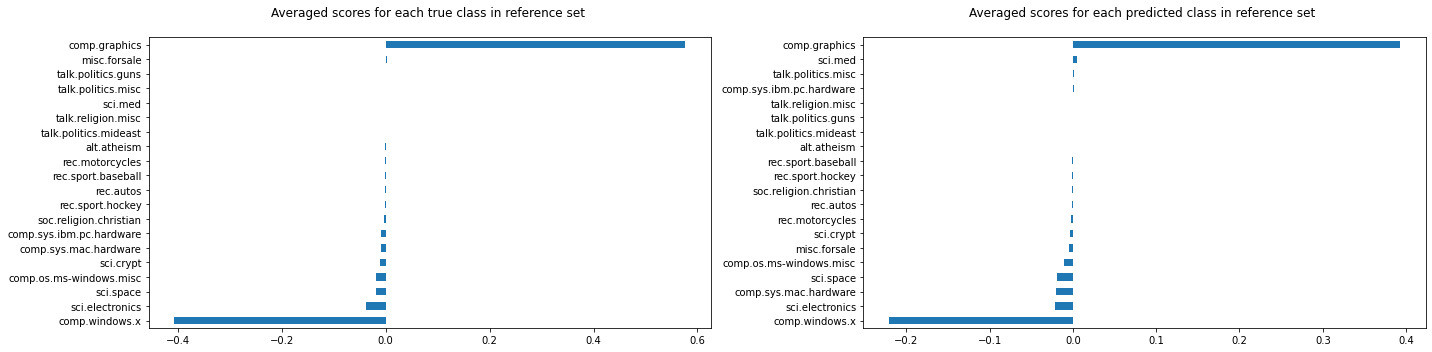

Sample nb 4

Original instance
Label: section 17, talk.politics.mideast
Prediction: section 17, talk.politics.mideast
Celebrating in joy the cold-blooded genocide of 2.5 million Muslim people by your criminal grandparents between 1914 and 1920? Did you think that you could cover up the genocide perpetrated by your fascist grandparents against my grandparents in 1914? You've never heard of 'April 23rd'? "In Soviet Armenia today there no longer exists a single Turkish soul. It is in our power to tear away the veil of illusion that some of us create for ourselves. It certainly is possible to severe the artificial life-support system of an imagined 'ethnic purity' that some of us falsely trust as the only structure that can support their heart beats in this alien land." (Sahak Melkonian - 1920 - "Preserving the Armenian purity") During the First World War and the ensuing years - 1914-1920, the Armenian Dictatorship through a premeditated and systematic genocide, tried to complete its centu

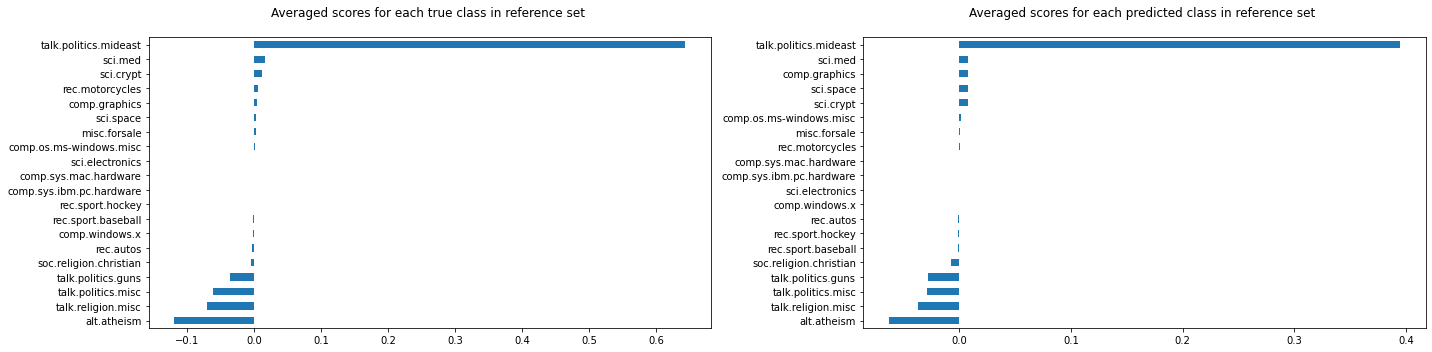

In [38]:
plot_distributions(ds, expls, target_names)